In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


import tarfile
tar = tarfile.open("drive/My Drive/Datasets/Dataset.tar.gz")
tar.extractall()
tar.close()

In [1]:
import cv2
import numpy as np
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import sys
import torch.nn.init
import os
from IPython.display import clear_output as clr

In [2]:
nu=2
use_cuda = False
class MyNet(nn.Module):
    def __init__(self,input_dim, nlast = 500):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 100, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = []
        self.bn2 = []
        for i in range(nu-1):
            self.conv2.append( nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(100) )
        
        self.conv3 = nn.Conv2d(100,nlast, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nlast)
        
        self.conv4 = nn.Conv2d(100,1, kernel_size=1, stride=1, padding=0 )
        self.bn4 = nn.BatchNorm2d(1)

    def forward(self, x):
#         print(self.conv2[0])
#         print(self.conv2[1])
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nu-1):
#             print(x.shape)
            x = self.conv2[i](x)
            x = F.relu( x )
#             print(x.shape)
            x = self.bn2[i](x)
#             print(x.shape)
        
        y = self.conv4(x)
        y = self.bn4(y)
      
        x = self.conv3(x)
        x = self.bn3(x)
        return x, y

In [ ]:
def dense_brightness_weight(img, sigma_X = 4, sigma_I = 10, r = 5):
    """
    Calculate bright_weight(connection) for image
    
    Args:
        image: ndarray [B,H,W,C].
        sigma_X: sigma for metric of distance.
        sigma_I: sigma for metric of intensity.
        r: radius of circle that only the neighbor in circle is considered.
    Returns:
        brightness_weight: ndarray [B, W*H, W*H]
    """
    
    B,N,M,C = img.shape
    
    image = img.cpu().numpy()
    weight_size = N*M
    batch_size = image.shape[0]
    bright_weights = np.zeros((batch_size,weight_size,weight_size))
    reduce_image = np.mean(image,axis = 3)
    
#     print(bright_weights.shape, reduce_image.shape)
    
    for batch in range(batch_size):
        # Reduce channel
        flat_image = np.ravel(reduce_image[batch])
        
        # Gaussian neighbor
        Fj, Fi = np.meshgrid(flat_image, flat_image)
        X, Y = list(zip(*np.ndindex(image.shape[1:3])))
        Xj, Xi = np.meshgrid(X,X)
        Yj, Yi = np.meshgrid(Y,Y)
        X_metric = np.sqrt((Xi - Xj)**2 + (Yi - Yj)**2)
        F_metric = np.abs(Fi - Fj)
        
        # Brightness weight
        bright_weight = np.exp(-(X_metric**2 / sigma_X**2) -(F_metric**2 / sigma_I**2))
        bright_weight[X_metric >= r] = 0
        bright_weights[batch] = bright_weight
        
    return bright_weights
  
def soft_ncut(img, cla):

    '''
    img : B x C x N x M
    cla : B x K x N x M
    '''


    B, C, N, M = img.shape
    K = cla.shape[1]
    weight_size = N*M

    cla = cla.view(B,K,N*M)
    img = torch.stack([img.transpose(0,3).transpose(1,2)[:,:,:,0]])
#     print(img.shape)
    image_weights = dense_brightness_weight(img)
    sum_image_weights = np.sum(image_weights,axis=-1)
    dis_assoc = torch.zeros((B,K))
    assoc = torch.zeros((B,K))
    for batch in range(B):
        # [K, H*W] @ [H*W, H*W] = [K, H*W]
        W_Ak = torch.mm(cla[batch], torch.tensor(image_weights[batch]).float().cuda()) # [K, H*W]
        dissoc = torch.mm(W_Ak, cla[batch].transpose(0,-1)) # [K, K]
        dis_assoc[batch] = torch.diag(dissoc) # [K]
        vec = torch.tensor(sum_image_weights[batch]).float().cuda()
        assoc[batch] = torch.matmul(cla[batch], vec) # [K]
    eps = 0.0000001
    soft_ncut = K - torch.sum((dis_assoc + eps) / (assoc + eps), 1)
    return soft_ncut

In [3]:
# train
model = MyNet(3)
if use_cuda:
    model.cuda()
    for i in range(nu-1):
        model.conv2[i].cuda()
        model.bn2[i].cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
loss_mse = torch.nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.1)
label_colours = np.random.randint(255,size=(100,3))
min_labels = 8
model.load_state_dict(torch.load('model.h5', map_location = 'cpu'))

In [ ]:
def train(frame1 , frame2):
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255

  # while(1):
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs, next, None,0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
  
  datav = torch.from_numpy( np.array([frame2.transpose( (2, 0, 1) ).astype('float32')/255.]) )
  datav = Variable(datav)
  if (use_cuda):
    datav = datav.cuda()
  labels1 = segmentation.slic(rgb, compactness=30, n_segments=1000)
  out1 = color.label2rgb(labels1, rgb, kind='avg')
  g = graph.rag_mean_color(rgb, labels1, mode='similarity')
  labels2 = graph.cut_normalized(labels1, g,thresh=0.5)
  out2 = color.label2rgb(labels2, frame2, kind='avg')

  edges = cv2.Canny(frame2,50,300)

  labels1d = segmentation.slic(frame2, compactness=10, n_segments=450)
  gd = graph.rag_mean_color(frame2, labels1d, mode='similarity')
  labels2d = graph.cut_normalized(labels1d, gd, thresh=0.001)
  
  
  mask=((out2[:,:,0]!=0)*1)
  
  label_train = labels2*mask + (labels2d+256)*(1-mask)

  # Finding the unique color segment labels ....
  labels = label_train.reshape(frame2.shape[0]*frame2.shape[1])
  u_labels = np.unique(labels)
  l_inds = []    


  ## finding he indices where that label exist....
  for i in range(len(u_labels)):
      l_inds.append(np.where(labels == u_labels[i])[0])

  
  for batch_idx in range(max_iter): #1000 is max iters
      # forwarding
      optimizer.zero_grad()
      output, edge_preds  = model(datav)
          
#       print(output.shape)
      
      ignore, target = torch.max(output[0].permute(1,2,0).contiguous().view(-1, 500), 1)
      im_target = target.data.cpu().numpy()
      nLabels = len(np.unique(im_target))

      # Superpixel Refinement 
      for i in range(len(l_inds)):
          labels_per_sp = im_target[l_inds[i]]

          # number of unique colors obtained in single super pixel .....along all channels...
          u_labels_per_sp = np.unique(labels_per_sp) 
          # hist : histogram of colors labels ...
          hist = np.zeros(len(u_labels_per_sp))
          for j in range(len(hist)):
              hist[j] = len(np.where(labels_per_sp == u_labels_per_sp[j])[0])
              
          # assinging the highest histogram value to whole super pixel
          im_target[l_inds[i]] = u_labels_per_sp[np.argmax(hist)]
      
      
      
      
      target = torch.from_numpy(im_target)
      if use_cuda:
          target = target.cuda()
      target = Variable(target)
          
      
#       masked_out = (output*mask)
#       masked_tar = (target.float()*mask).view(1,edges.shape[0],edges.shape[1])
   
  
      print(output.shape)
      loss1 = loss_fn(output, target.to(dtype = torch.int64).view(1, frame2.shape[0], frame2.shape[1]))
      loss2 = soft_ncut(datav, output).cuda()*0.000001
      loss = loss1 + loss2
      
      n_labels = np.unique(im_target)[0]
      if(n_labels < min_labels and loss1 < 3):
        print("Conditional Breaking")
        return
      
      loss.backward()
      optimizer.step()
      
      print (batch_idx, '/',max_iter, ':', loss1.data, loss2.data)

In [191]:
max_iter = 10
for epochs in range(10):
  for num in [2,3,4,5,1]:
    path1 = './Dataset/camera'+str(num)+'/JPEGImages'
    folder_path = path1
    rand = np.random.randint(300)
    file_names = sorted(os.listdir(folder_path))[rand:rand+10]
    file_index = 0
    num_images = len(file_names)
    batch_size = 1
    
    for batch_number in range(0,num_images // batch_size - 1):
      batch = []
      for i in range(0,batch_size):
        filename = os.path.join(folder_path, file_names[file_index])
        filename2 = os.path.join(folder_path, file_names[file_index+1])

        frame1 = cv2.resize(cv2.imread(filename), (64,64))
        frame2 = cv2.resize(cv2.imread(filename2), (64,64))
        
        torch.cuda.empty_cache()
        train(frame1, frame2)
      
      print("Epoch:",epochs, num)
      torch.cuda.empty_cache()
      if(batch_number%5 == 0):
        clr(wait = True)

torch.Size([1, 500, 64, 64])
0 / 10 : tensor(5.4533, device='cuda:0') tensor([0.0009], device='cuda:0')
torch.Size([1, 500, 64, 64])
1 / 10 : tensor(5.1579, device='cuda:0') tensor([0.0007], device='cuda:0')
torch.Size([1, 500, 64, 64])
2 / 10 : tensor(4.6083, device='cuda:0') tensor([0.0007], device='cuda:0')
torch.Size([1, 500, 64, 64])
3 / 10 : tensor(4.2030, device='cuda:0') tensor([0.0007], device='cuda:0')
torch.Size([1, 500, 64, 64])
4 / 10 : tensor(3.8119, device='cuda:0') tensor([0.0004], device='cuda:0')
torch.Size([1, 500, 64, 64])


KeyboardInterrupt: ignored

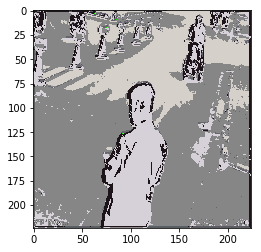

In [27]:
img = cv2.resize(cv2.imread('../../Dataset/camera4/JPEGImages/00001.jpg'), (224,224))
# img = cv2.resize(cv2.imread('../../sample2.jpg'), (224,224))
datav = torch.from_numpy( np.array([img.transpose( (2, 0, 1) ).astype('float32')/255.]) )
datav = Variable(datav)
if(use_cuda):
    datav = datav.cuda()
output = model(datav)[0][0]
_, labels_pred = torch.max(output,0)
im_target_rgb = color.label2rgb(labels_pred.cpu().numpy(), img, kind = 'rgb')
plt.imshow(im_target_rgb*2)
plt.savefig('ONWS02.png')

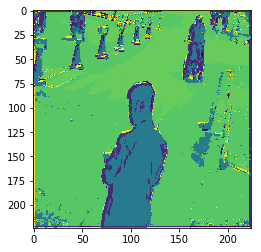

In [28]:
plt.imshow(labels_pred.cpu().numpy())
plt.savefig('ONWS01.png')

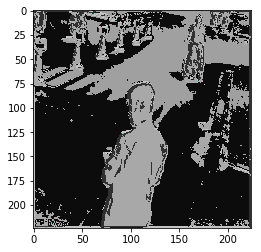

In [35]:
g = graph.rag_mean_color(img, im_target_rgb.reshape((224,224,3)), mode='similarity')
labels2 = graph.cut_normalized(im_target_rgb.reshape((224,224,3)), g, thresh=0.5)
out2 = color.label2rgb(labels2, img, kind='avg')


plt.imshow(out2*4)
# plt.savefig("ncut.png")
plt.show()

In [183]:
output.shape

torch.Size([500, 256, 256])

In [ ]:
torch.save(model.state_dict(), 'model.h5')

In [ ]:
g = graph.rag_mean_color(im_target_rgb, labels_pred.cpu().numpy(), mode='similarity')
labels2 = graph.cut_normalized(labels_pred.cpu().numpy(), g, thresh=0.1)
out2 = color.label2rgb(labels2, img, kind='avg')

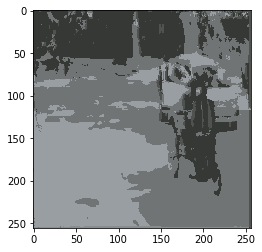

In [174]:
plt.imshow(out2)

In [ ]:
+